In [1]:
%reload_ext autoreload
%autoreload 2

## What is this pipeline?

This data pipeline takes the 2D position (in video pixels) of the green and red LEDs tracked by Trodes, and computes:
+ head position (in cm)
+ head orientation (in radians)
+ head velocity (in cm/s)
+ head speed (in cm/s)

We can then check the quality of the head position and direction by plotting the them on the video along with the oringal green and red LEDs.

This notebook will take you through this process for one dataset.

## 1. Loading the session data

First let us make sure that the session we want to analyze is inserted into the database:

In [28]:
import spyglass as nd

nwb_file_name = 'molly20220415.nwb'

After insert, a new nwb file is made that is a copy of the original version without the electrophysiological data. This name is used as a key in the downstream data analysis so we save the name of the copied version for later use.

In [29]:
from spyglass.common.nwb_helper_fn import get_nwb_copy_filename

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
nwb_copy_file_name

'molly20220415_.nwb'

## 2. Setting the parameters for running the position pipeline

The parameters for the position pipeline are set by the `PositionInfoParameters` table. `default` is the name of the standard set of parameters. As usual, if you want to change the parameters, you can insert your own into the table.

The parameters are as follows:

+ `max_separation` is the maxmium acceptable distance (in cm) between the red and green LEDs. When the distance between the LEDs becomes greater than this number, the times are marked as NaNs and inferred by interpolation. This is useful parameter when the inferred red or green LED position tracks a reflection instead of the true red or green LED position. It is set to 9.0 cm by default.
+ `max_speed` is the maximum plausible speed (in cm/s) the animal can move at. Times when the speed is greater than this threshold are marked as NaNs and inferred by interpolation. This can be useful in preventing big, sudden jumps in position. It is set to 300.0 cm/s by default.
+ `position_smoothing_duration` controls how much the red and green LEDs are smoothed before computing the average of their position to get the head position. It is in units of seconds.
+ `speed_smoothing_std_dev` controls how much the head speed is smoothed. It corresponds to the standard deviation of the Gaussian kernel used to smooth the speed and is in units of seconds. It is set to 0.100 seconds by default.
+ `front_led1` is either 1 or 0 indicating True or False. It controls which LED is treated as the front LED and the back LED, which is important for calculating the head direction.
    + 1 indicates that the LED corresponding to `xloc`, `yloc` in the `RawPosition` table as the front LED and the LED corresponding to `xloc2`, `yloc2` as the back LED.
    + 0 indicates that `xloc`, `yloc` are treated as the back LED and `xloc2`, `yloc2` are treated as the front LED.

In [5]:
from spyglass.common.common_position import PositionInfoParameters

PositionInfoParameters()

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default,9.0,300.0,0.125,0.1,0.001,1,0,nan,linear
default_decoding,9.0,300.0,0.125,0.1,0.001,1,1,500.0,linear
default_lfp,9.0,300.0,0.125,0.1,0.001,1,1,1000.0,linear


In [6]:
PositionInfoParameters.insert1({'position_info_param_name': 'default'}, skip_duplicates=True)
PositionInfoParameters()

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default,9.0,300.0,0.125,0.1,0.001,1,0,nan,linear
default_decoding,9.0,300.0,0.125,0.1,0.001,1,1,500.0,linear
default_lfp,9.0,300.0,0.125,0.1,0.001,1,1,1000.0,linear


Now that you have set the parameters, you need to associate those parameters with a partiuclar nwb file and interval using the `IntervalPositionInfoSelection` table in order to run the position pipeline.

Let's look at the intervals for `chimi20200216_new.nwb` first. We care about the intervals that start with `pos` and ending with `valid times`.

In [7]:
import pandas as pd

pd.DataFrame(nd.common.IntervalList &
             {'nwb_file_name': nwb_copy_file_name})

,nwb_file_name,interval_list_name,valid_times
0,molly20220420_.nwb,01_Seq2Sleep1,"[[1650470915.4374735, 1650472728.381393]]"
1,molly20220420_.nwb,02_Seq2Session1,"[[1650472773.2327273, 1650474963.2809827]]"
2,molly20220420_.nwb,03_Seq2Sleep2,"[[1650475082.0098395, 1650477389.881148]]"
3,molly20220420_.nwb,04_Seq2Session2,"[[1650477452.8794122, 1650479692.781361]]"
4,molly20220420_.nwb,05_Seq2Sleep3,"[[1650479832.5955963, 1650481649.6815033]]"
5,molly20220420_.nwb,06_Seq2Session3,"[[1650481695.8621364, 1650483999.7814517]]"
6,molly20220420_.nwb,07_Seq2Sleep4,"[[1650484201.4638813, 1650486067.2809312]]"
7,molly20220420_.nwb,08_Seq2Session4,"[[1650486256.0662096, 1650488630.4817128]]"
8,molly20220420_.nwb,09_Seq2Sleep5,"[[1650489090.053734, 1650491501.6816893]]"
9,molly20220420_.nwb,10_Seq2Session5,"[[1650491727.8002121, 1650494301.981564]]"


Let's choose the interval corresponding to `pos 1 valid times` in `chimi20200216_new_.nwb`.

We first look at the "raw" position data now to see the input into the pipeline. The raw position is in the `RawPosition` table and corresponds to the inferred position of the red and green LEDs from the video (using an algorithm in Trodes). It is in units of pixels. The number of time points corresponds to when the position tracking was turned on and off (and so may not have the same number of time points as the video itself).

We can retrieve the data in the `RawPosition` table for a given interval using a special method called `fetch1_dataframe`. It returns the position of the red and green LEDs as a pandas dataframe where time is the index. The columns of the dataframe are:
+ `xloc`, `yloc` are the x- and y-position of one of the LEDs
+ `xloc2`, `yloc2` are the x- and y-position of the other LEDs.

In [8]:
from spyglass.common.common_behav import RawPosition

raw_position_df = (RawPosition() &
                   {'nwb_file_name': nwb_copy_file_name,
                    'interval_list_name': 'pos 1 valid times'}).fetch1_dataframe()
raw_position_df

,xloc,yloc,xloc2,yloc2
time,,,,
1.650473e+09,1014,245,0,0
1.650473e+09,845,946,828,919
1.650473e+09,845,946,828,919
1.650473e+09,845,946,830,919
1.650473e+09,844,945,831,919
...,...,...,...,...
1.650473e+09,741,196,733,183
1.650473e+09,732,193,732,184
1.650473e+09,739,192,732,183


Let's just quickly plot the two LEDs to get a sense of the inputs to the pipeline:

Text(0.5, 1.0, 'Raw Position')

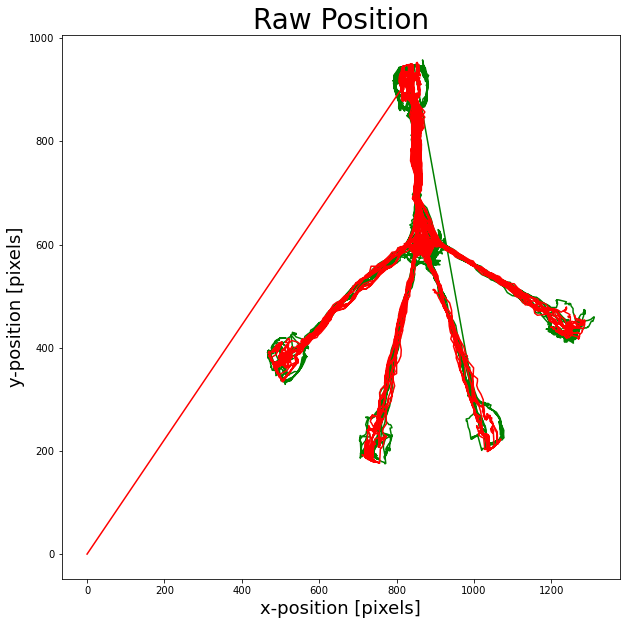

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(raw_position_df.xloc, raw_position_df.yloc, color='green')
ax.plot(raw_position_df.xloc2, raw_position_df.yloc2, color='red')
ax.set_xlabel('x-position [pixels]', fontsize=18)
ax.set_ylabel('y-position [pixels]', fontsize=18)
ax.set_title('Raw Position', fontsize=28)

Okay, now that we understand what the inputs to the pipeline are, let's associate a set of parameters with a given interval.

To associate parameters with a given interval, we insert them into the `IntervalPositionInfoSelection` table.

Here we associate the with the `default` position info parameters with the interval `pos 1 valid times`:

In [10]:
from spyglass.common.common_position import IntervalPositionInfoSelection

IntervalPositionInfoSelection.insert1(
    {'nwb_file_name': nwb_copy_file_name,
     'interval_list_name': 'pos 5 valid times',
     'position_info_param_name': 'default'
    }, skip_duplicates=True)

IntervalPositionInfoSelection.insert1(
    {'nwb_file_name': nwb_copy_file_name,
     'interval_list_name': 'pos 5 valid times',
     'position_info_param_name': 'default_decoding'
    }, skip_duplicates=True)

Now let's check to see if we've inserted the parameters correctly:

In [11]:
IntervalPositionInfoSelection()&{'nwb_file_name': nwb_copy_file_name}

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list
default,molly20220420_.nwb,pos 5 valid times
default_decoding,molly20220420_.nwb,pos 5 valid times


## 3. Running the position pipeline and retrieving the results

Now that we have associated the parameters with the interval we want to run, we can finally run the pipeline for that interval.

We run the pipeline using the `populate` method on the `IntervalPositionInfo` table.

In [12]:
from spyglass.common.common_position import IntervalPositionInfo

IntervalPositionInfo.populate()

Computing position for: {'position_info_param_name': 'default', 'nwb_file_name': 'molly20220420_.nwb', 'interval_list_name': 'pos 5 valid times'}
Writing new NWB file molly20220420_LUUWQWG4TQ.nwb
Computing position for: {'position_info_param_name': 'default_decoding', 'nwb_file_name': 'molly20220420_.nwb', 'interval_list_name': 'pos 5 valid times'}
Writing new NWB file molly20220420_AO644VSQ8R.nwb


We can see that each NWB file, interval, and parameter set is now associated with a newly created analysis NWB file and object IDs that correspond to our newly computed data. This isn't as useful to work with so we will use another method below to actually retrieve the data for a given interval.

In [13]:
IntervalPositionInfo()&{'nwb_file_name': nwb_copy_file_name}

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,analysis_file_name name of the file,head_position_object_id,head_orientation_object_id,head_velocity_object_id
default,molly20220420_.nwb,pos 5 valid times,molly20220420_LUUWQWG4TQ.nwb,bcabcaf2-eb58-4115-b447-7688e8f2faee,6aa32bb6-9f9b-4db2-985a-f621a9af771d,9ff97cc9-d4f9-464d-9047-1143cdc90f2f
default_decoding,molly20220420_.nwb,pos 5 valid times,molly20220420_AO644VSQ8R.nwb,0fa87303-8fd2-4e93-b108-7be74f083b37,61789d6b-3821-4c69-9f1e-1ef583534bd8,682e532b-4783-4d46-8a01-2771943fadae


In order to retrieve the results of the computation, we use a special method called `fetch1_dataframe` from the `IntervalPositionInfo` table that will retrieve the position pipeline results as a pandas DataFrame. Time is set as the index of the dataframe.

This will only work for a single interval so we need to specify the NWB file and the interval.

This dataframe has the following columns:
+ `head_position_x`, `head_position_y`: the x,y position of the head position (in cm).
+ `head_orientation`: The direction of the head relative to the bottom left corner (in radians)
+ `head_velocity_x`, `head_velocity_y`: the directional change in head position over time (in cm/s)
+ `head_speed`: the magnitude of the change in head position over time (in cm/s)

In [19]:
position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': 'pos 5 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.650482e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.650482e+09,67.04,74.76,1.292497,NaN,NaN,NaN
1.650482e+09,67.06,74.76,1.186192,NaN,NaN,NaN
1.650482e+09,67.06,74.80,1.012197,NaN,NaN,NaN
1.650482e+09,67.10,74.92,0.831519,NaN,NaN,NaN
...,...,...,...,...,...,...
1.650484e+09,66.46,74.66,2.074423,-5.465343,0.932242,5.544280
1.650484e+09,66.20,74.68,2.228685,-5.709904,1.040298,5.803897
1.650484e+09,65.88,74.88,2.441700,-5.538397,0.978371,5.624149


If you are not familiar with pandas, the time variable is set as the index. It can be accessed using `.index` on the dataframe.

In [14]:
position_info.index

Float64Index([1581886916.3153033, 1581886916.3486283, 1581886916.3819742,
              1581886916.4152992,  1581886916.448645, 1581886916.4819698,
              1581886916.5152948, 1581886916.5486405, 1581886916.5819652,
              1581886916.6152902,
              ...
              1581888227.3021932,  1581888227.335518,  1581888227.368864,
              1581888227.4021888,  1581888227.435535, 1581888227.4688597,
              1581888227.5021844, 1581888227.5355306, 1581888227.5688553,
                1581888227.60218],
             dtype='float64', name='time', length=39340)

## 4. Examining the results

We should always spot check our results to verify that the pipeline worked correctly.

### Plots
Let's plot some of the variables first:

Text(0.5, 1.0, 'Head Position')

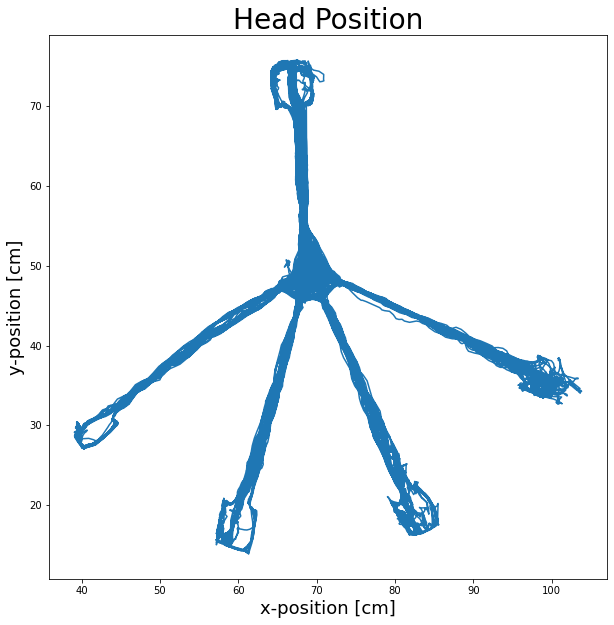

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_position_x, position_info.head_position_y)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
ax.set_title('Head Position', fontsize=28)

Text(0.5, 1.0, 'Head Velocity')

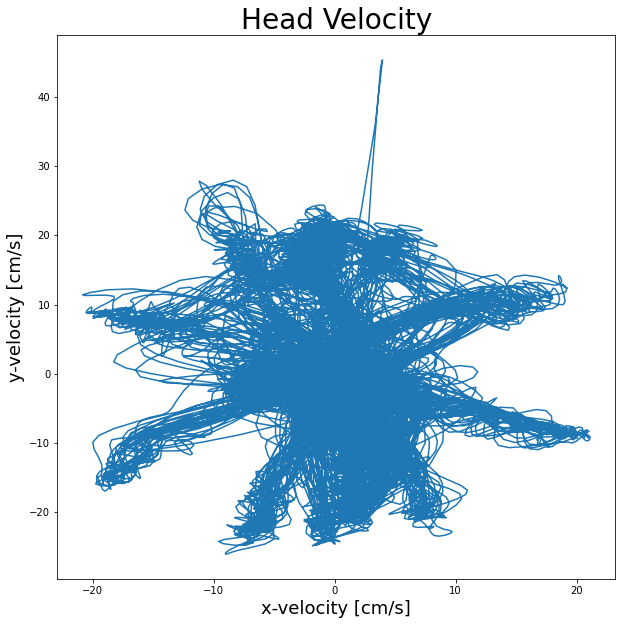

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_velocity_x, position_info.head_velocity_y)
ax.set_xlabel('x-velocity [cm/s]', fontsize=18)
ax.set_ylabel('y-velocity [cm/s]', fontsize=18)
ax.set_title('Head Velocity', fontsize=28)

(1650481746.7747982, 1650483999.7197618)

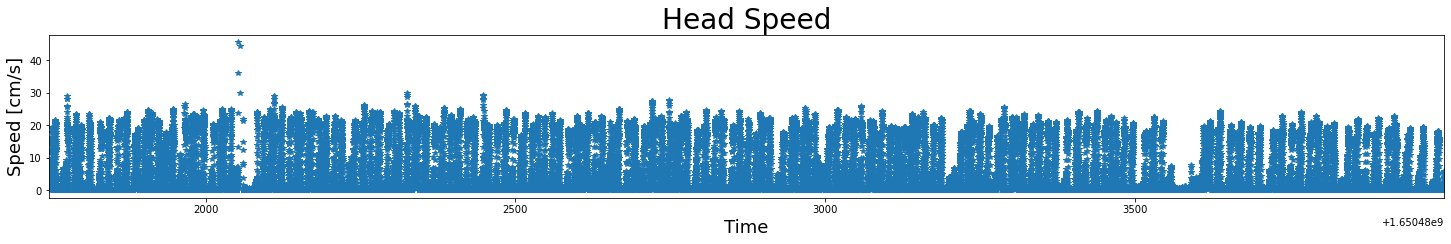

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
ax.plot(position_info.index, position_info.head_speed,'*')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Speed [cm/s]', fontsize=18)
ax.set_title('Head Speed', fontsize=28)
ax.set_xlim((position_info.index.min(), position_info.index.max()))

### Video

These look reasonable but it is better to evaluate these variables by plotting the results on the video where we can see how they correspond. 

The video will appear in the current working directory when it is done.

In [30]:
from spyglass.common.common_position import PositionVideo

PositionVideo().make({'nwb_file_name': nwb_copy_file_name,
                      'interval_list_name': 'pos 3 valid times',
                      'position_info_param_name': 'default'
                     })

Loading position data...
Loading video data...
Making video...


frames:   0%|          | 0/47138 [00:00<?, ?it/s]

## 4. Upsampling position data

Sometimes you need the position data to be in a different rate than it is sampled in, such as when decoding in 2 ms time bins. You can use the upsampling parameters to get this data:
+ `is_upsampled` controls whether upsampling happens. If it is 1 then there is upsampling, and if it is 0 then upsampling does not happen.
+ `upsampling_sampling_rate` is the rate you want to upsample to. For example position is typically recorded at 33 frames per seconds and you may want to upsample up to 500 frames per second.
+ `upsampling_interpolation_method` is the interpolation method used for upsampling. It is set to linear by default. See the methods available for pandas.DataFrame.interpolate to get a list of the methods.

In [20]:
PositionInfoParameters.insert1(
    {'position_info_param_name': 'default_decoding',
     'is_upsampled': 1,
     'upsampling_sampling_rate': 500,
    }, skip_duplicates=True)

PositionInfoParameters()

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default,9.0,300.0,0.125,0.1,0.001,1,0,nan,linear
default_decoding,9.0,300.0,0.125,0.1,0.001,1,1,500.0,linear


In [21]:
IntervalPositionInfoSelection.insert1(
    {'nwb_file_name': nwb_copy_file_name,
     'interval_list_name': 'pos 1 valid times',
     'position_info_param_name': 'default_decoding'
    }, skip_duplicates=True)

IntervalPositionInfoSelection()

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list
default,chimi20200216_new_.nwb,pos 1 valid times
default_decoding,chimi20200216_new_.nwb,pos 1 valid times


In [22]:
IntervalPositionInfo.populate()

Computing position for: {'position_info_param_name': 'default_decoding', 'nwb_file_name': 'chimi20200216_new_.nwb', 'interval_list_name': 'pos 1 valid times'}
Writing new NWB file chimi20200216_new_6YC9LPAR7S.nwb


In [23]:
upsampled_position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default_decoding'}
                ).fetch1_dataframe()

upsampled_position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.581887e+09,91.051650,211.127050,2.680048,1.741550,2.301478,2.886139
1.581887e+09,91.039455,211.144123,3.003241,1.827555,2.333931,2.964320
1.581887e+09,91.027260,211.161196,3.008398,1.915800,2.366668,3.044898
1.581887e+09,91.015065,211.178268,3.012802,2.006286,2.399705,3.127901
1.581887e+09,91.002871,211.195341,3.017242,2.099012,2.433059,3.213352
...,...,...,...,...,...,...
1.581888e+09,182.158583,201.299625,-0.944304,0.057520,-0.356012,0.360629
1.581888e+09,182.158583,201.296373,-0.942329,0.053954,-0.356343,0.360404
1.581888e+09,182.158583,201.293121,-0.940357,0.050477,-0.356407,0.359964


Text(0.5, 1.0, 'Upsampled Head Position')

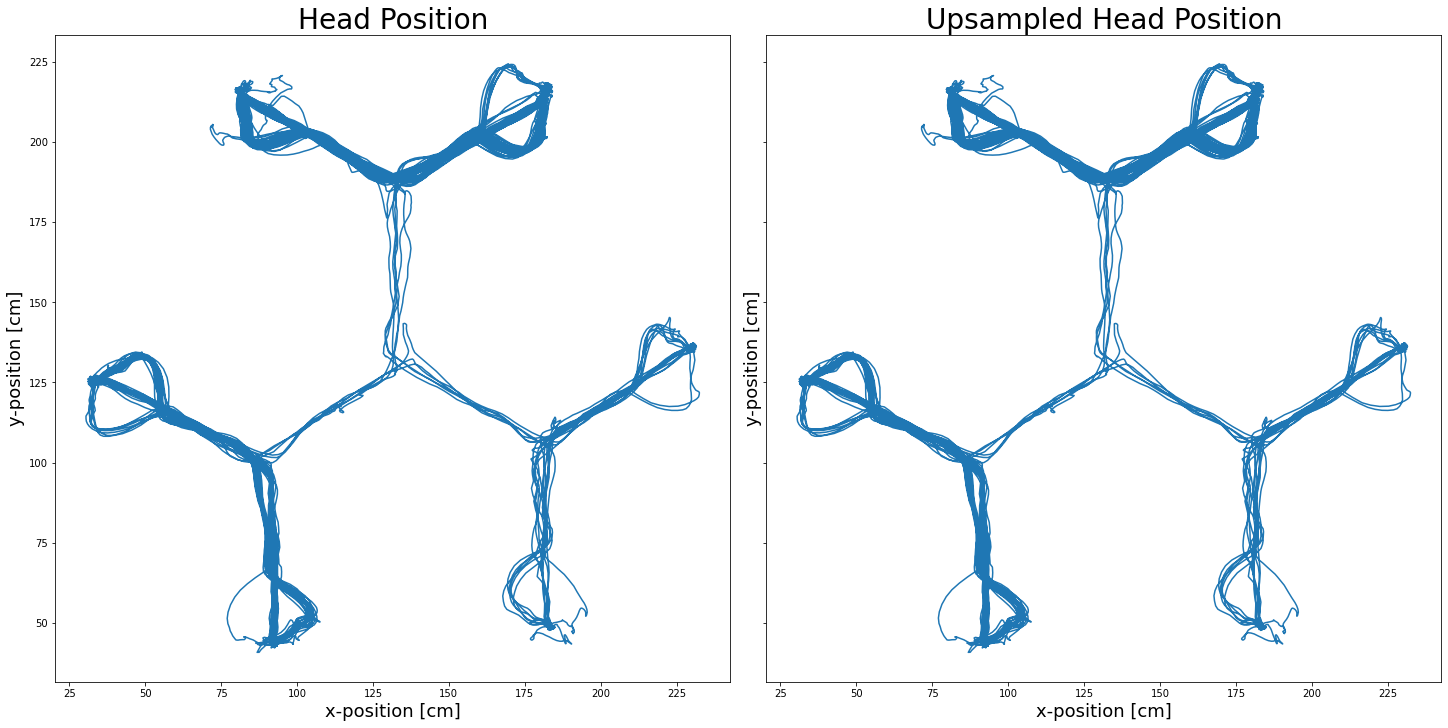

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
axes[0].plot(position_info.head_position_x, position_info.head_position_y)
axes[0].set_xlabel('x-position [cm]', fontsize=18)
axes[0].set_ylabel('y-position [cm]', fontsize=18)
axes[0].set_title('Head Position', fontsize=28)

axes[1].plot(upsampled_position_info.head_position_x, upsampled_position_info.head_position_y)
axes[1].set_xlabel('x-position [cm]', fontsize=18)
axes[1].set_ylabel('y-position [cm]', fontsize=18)
axes[1].set_title('Upsampled Head Position', fontsize=28)

Text(0.5, 1.0, 'Upsampled Head Speed')

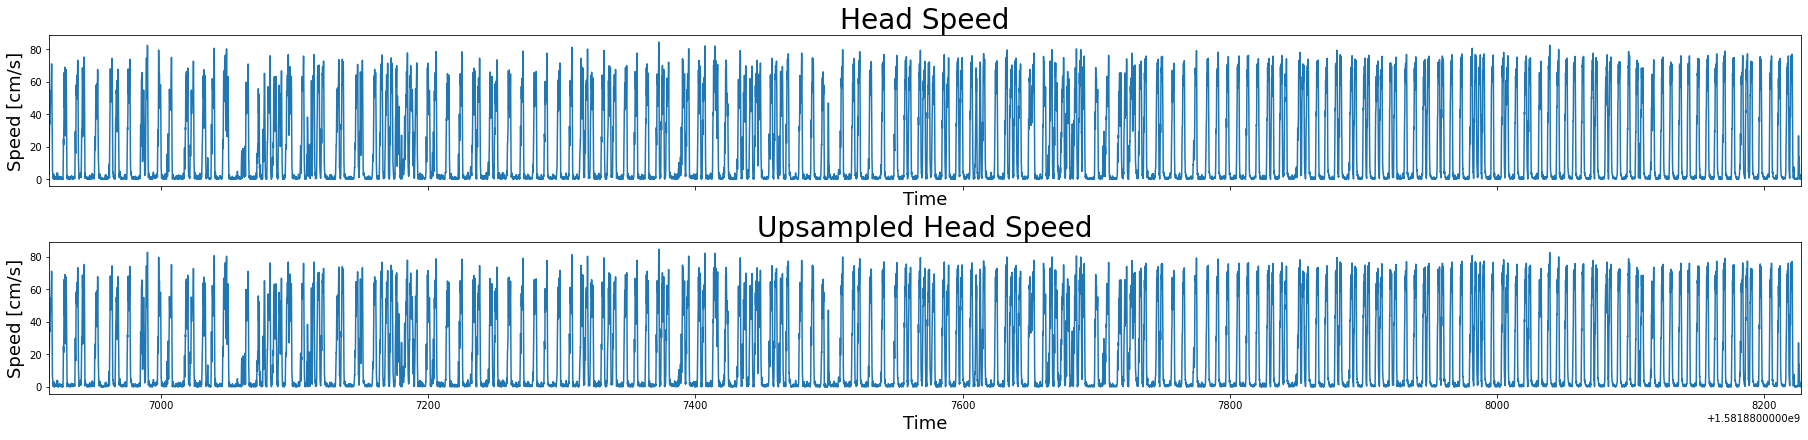

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(25, 6), sharex=True, sharey=True, constrained_layout=True)
axes[0].plot(position_info.index, position_info.head_speed)
axes[0].set_xlabel('Time', fontsize=18)
axes[0].set_ylabel('Speed [cm/s]', fontsize=18)
axes[0].set_title('Head Speed', fontsize=28)
axes[0].set_xlim((position_info.index.min(), position_info.index.max()))

axes[1].plot(upsampled_position_info.index, upsampled_position_info.head_speed)
axes[1].set_xlabel('Time', fontsize=18)
axes[1].set_ylabel('Speed [cm/s]', fontsize=18)
axes[1].set_title('Upsampled Head Speed', fontsize=28)

Text(0.5, 1.0, 'Upsampled Head Velocity')

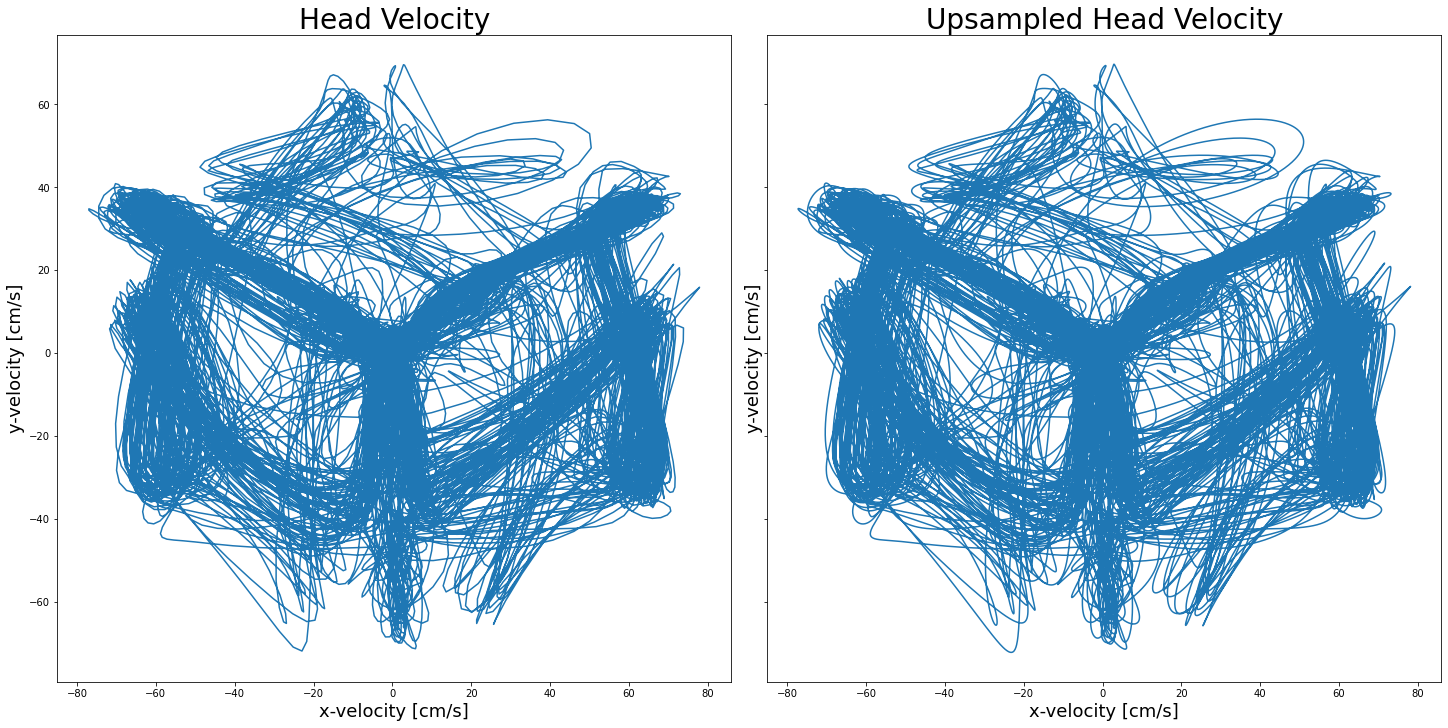

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
axes[0].plot(position_info.head_velocity_x, position_info.head_velocity_y)
axes[0].set_xlabel('x-velocity [cm/s]', fontsize=18)
axes[0].set_ylabel('y-velocity [cm/s]', fontsize=18)
axes[0].set_title('Head Velocity', fontsize=28)

axes[1].plot(upsampled_position_info.head_velocity_x, upsampled_position_info.head_velocity_y)
axes[1].set_xlabel('x-velocity [cm/s]', fontsize=18)
axes[1].set_ylabel('y-velocity [cm/s]', fontsize=18)
axes[1].set_title('Upsampled Head Velocity', fontsize=28)